In [4]:
%reset -f

# from pandasgui import show

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from functions import *

%load_ext autoreload
%autoreload 2

# Load data
data = pd.read_csv('Data/non_nan_data.csv')
data = data.drop(['sun_mean', 'wind_mean', 'temp_mean', 'DK1_spot'], axis=1)

cols_to_lag = [col for col in data.columns if col.startswith('sun_') or col.startswith('temp_') or col.startswith('wind_')]
data[cols_to_lag] = data[cols_to_lag].shift(24)

lags_list = [24, 48, 72, 96, 120, 144, 168]

# Create columns with DK1_spot 24 hours lagged
for i in lags_list:
    data[f'DK2_spot_lag_{i}'] = data['DK2_spot'].shift(i)

data = data.dropna()

# Split data
data_train = data[(data['DATE'] >= '2014-01-01') & (data['DATE'] < '2023-01-01')].drop(['DATE'], axis=1).to_numpy()
data_test = data[data['DATE'] >= '2023-01-01'].drop(['DATE'], axis=1).to_numpy()

# To only use weather data one hour before the price, we lag weather data one hour
y_train = data_train[:, 0].reshape(-1, 1)
y_test = data_test[:, 0].reshape(-1, 1)

weather_train = data_train[:, 1:-len(lags_list)]
weather_test = data_test[:, 1:-len(lags_list)]

lags_train = data_train[:, -len(lags_list):]
lags_test = data_test[:, -len(lags_list):]

hour_dummies_train = sdummy(len(data_train), 24)
hour_dummies_test = sdummy(len(data_test), 24)

all_train = np.concatenate((weather_train, hour_dummies_train), axis=1)
all_test = np.concatenate((weather_test, hour_dummies_test), axis=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\peter\AppData\Local\Temp\ipykernel_27148\581827568.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'DK2_spot_lag_{i}'] = data['DK2_spot'].shift(i)
C:\Users\peter\AppData\Local\Temp\ipykernel_27148\581827568.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'DK2_spot_lag_{i}'] = data['DK2_spot'].shift(i)
C:\Users\peter\AppData\Local\Temp\ipykernel_27148\581827568.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

## Seasonal ARMA

In [ ]:
# Fit SARIMAX model
# Replace (p, d, q) and (P, D, Q, s) with appropriate orders based on your data
p, d, q = 0, 0, 0 
P, D, Q, s = [24], 0, [24], 24 

smoother_output = 0

model = SARIMAX(
    y_train,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    **{'smoother_output': smoother_output}
)
results = model.fit(disp=False)

# Use the model to predict without refitting
new_results = results.append(y_test, refit=False)

# Get predictions for the test period
predictions = new_results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

smape_baseline = smape(y_test, predictions.reshape(-1, 1))

print(f'SMAPE baseline (24 lags) out of sample prediction: {smape_baseline}')

plot_actual_vs_predicted(y_test, predictions, "Seasonal SARIMA predictions")

## ARMA

SMAPE baseline (24 lags) out of sample prediction: 22.858720969221633


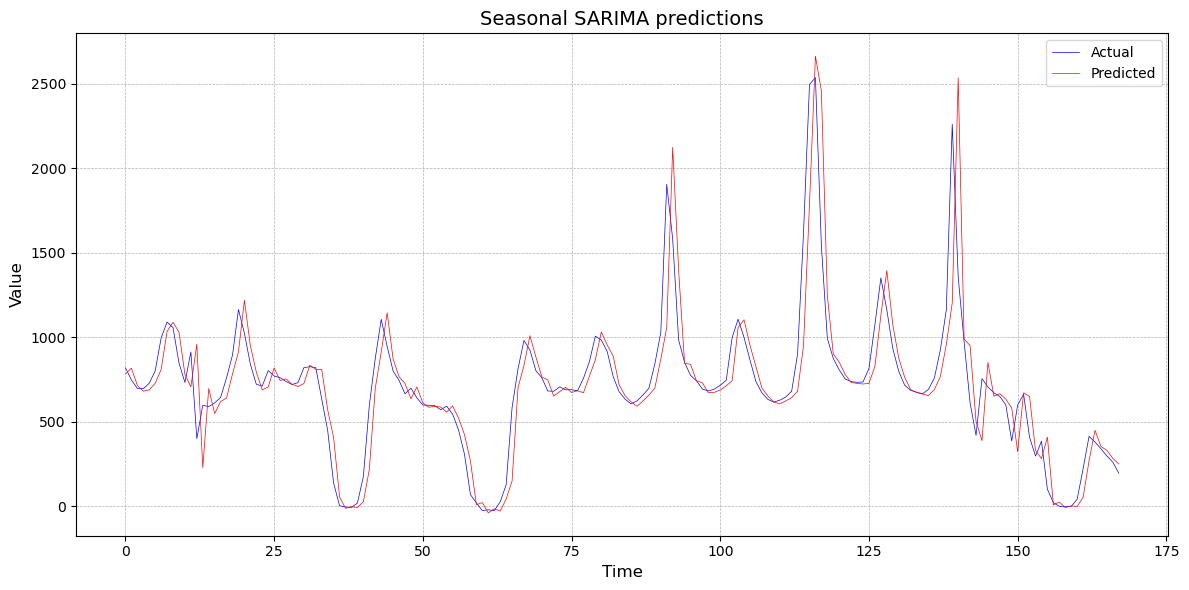

In [92]:
p, d, q = 1, 0, 1
P, D, Q, s = 0, 0, 0, 0  # No seasonal component for simplicity

smoother_output = 0

model = SARIMAX(
    y_train,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    **{'smoother_output': smoother_output}
)
results = model.fit(disp=False)

# Use the model to predict without refitting
new_results = results.append(y_test, refit=False)

# Get predictions for the test period
predictions = new_results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

smape_baseline = smape(y_test, predictions)

print(f'SMAPE baseline (24 lags) out of sample prediction: {smape_baseline}')

plot_actual_vs_predicted(y_test, predictions, "Seasonal SARIMA predictions")